# Forecasts using an Autoencoder/LSTM model with Ta-Lib
#### By: Mohamed BELLOUCH, Data INE3

I aim through this project to put into practice the basics of the Ta-Lib library, and then I will attempt to build an LSMT model that contains additional layers to get its own representation of the input data instead of using a Ta-Lib function, and a second one, which is an autoencoder, to compress the input data as windows before applying the LSTM.

## Contents

[1. Set up of the environment](#scrollTo=t3Ze5STZ8XDn)

>[1.1. Install yfinance and mplfinance](#scrollTo=f6xpp_JK8c6m) \\
>[1.1. Install Ta-Lib](#scrollTo=AN0Ongbz8ypi) \\
>[1.3. Import the libraries](#scrollTo=BOWxB5j89r-N) \\
>[1.4. Load the Apple data](#scrollTo=4Pj52VPbWBmk) \\

[2. Basic K-line charts](#scrollTo=ccb1XMQm-CxJ)

[3. Basic manipulations of Ta-Lib](#scrollTo=odARLCydOjxE)

[4. Data processing](#scrollTo=P7-KsmlUcNhJ)

[5. The first model](#scrollTo=97_mO7Geibc1)

>[5.1. The idea](#scrollTo=wq6_bC60mWuP) \\
>[5.2. Building the model](#scrollTo=N_mkrA8ADrq2) \\
>[5.3. Model predictions](#scrollTo=a7kNCuauwxIg) \\
>[5.4. Evaluation](#scrollTo=XOofCbDkIOdB)

[6. The second model : LSTM on autoencoded representation](#scrollTo=cjpRcFf4gXaZ)

>[6.1. The idea ](#scrollTo=wq6_bC60mWuP) \\
>[6.2. Building the model](#scrollTo=N_mkrA8ADrq2) \\
>[6.3. Model predictions](#scrollTo=a7kNCuauwxIg) \\
>[6.4. Evaluation](#scrollTo=XOofCbDkIOdB)


## 1. Set up of the environment

### 1.1. Install `yfinance` and `mplfinance`

In [3]:
# set up of the environment
!pip install yfinance
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 4.0 MB 9.4 MB/s 
     |████████████████████████████████| 110 kB 76.5 MB/s 
     |████████████████████████████████| 112 kB 76.7 MB/s 
     |████████████████████████████████| 128 kB 72.7 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https:

### 1.1. Install `Ta-Lib`

In [4]:
# Ta-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-12-28 18:25:04--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-28 18:25:04--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-28 18:25:04--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

### 1.3. Import the libraries

In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
import talib
import mplfinance as mpf
from tqdm import tqdm

#Data normalization
from sklearn.preprocessing import MinMaxScaler  

In [10]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

from math import sqrt
from keras.utils.vis_utils import plot_model  # plot_model  
from  sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

### 1.4. Load the Apple data

In [11]:
df = pd.read_csv('/content/AAPL_Daily.csv').set_index('Date')
df.head()
df.index = pd.DatetimeIndex(df.index)

## 2. Basic K-line charts

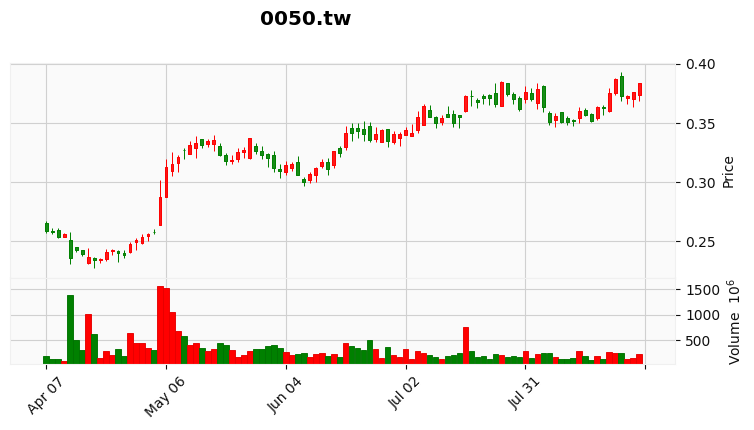

In [12]:
#Draw K-line chart
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
exterior = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
k_plot = mpf.plot(df.iloc[100:200], style=exterior, type='candle', volume=True, figratio=(30,14), figscale=0.75, title='0050.tw',)

Let's hide the volume and add a simple moving average!

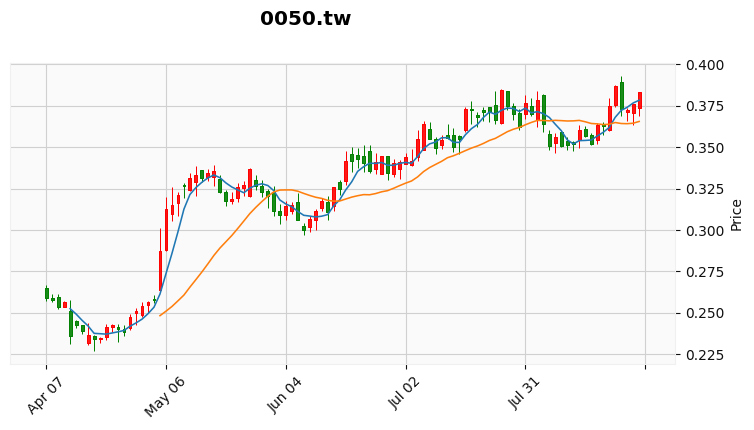

In [13]:
k_sma_plot = mpf.plot(df.iloc[100:200], style=exterior, type='candle', mav=(5,20), figratio=(30,14), figscale=0.75, title='0050.tw',)

To plot other types of moving averages, such as the exponential moving average, we will have to calculate it and add it to the chart separately. Hence the need for Ta-Lib :

## 3. Basic manipulations of Ta-Lib



Let's count the functions of Ta-Lib 

In [14]:
len(talib.get_functions())

158

To list these functions by group, we can try the following:

```
for group, funcs in talib.get_function_groups().items():
    print(group)
    print('-----------------------------------------')
    for func in funcs:
        f = Function(func)
        print('{} - {}'.format(func, f.info['display_name']))
    print()
```



This is Ta-Lib's function to compute Exponential Moving Average 

In [15]:
#talib.EMA?

Uncomment it to display this description:
```
Docstring:
EMA(real[, timeperiod=?])

Exponential Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function
```

Note that the default value of the timeperiod parameter is 14.

We will compute it and add it to the graph later:

In [16]:
ema = talib.EMA(df.Close, timeperiod=30)
ema.loc[df.iloc[100:200].index]

Date
2003-04-07    0.259987
2003-04-08    0.259861
2003-04-09    0.259444
2003-04-10    0.259261
2003-04-11    0.257742
                ...   
2003-08-21    0.360334
2003-08-22    0.361142
2003-08-25    0.361875
2003-08-26    0.362779
2003-08-27    0.364121
Length: 100, dtype: float64

Let't add this plot to the chart :

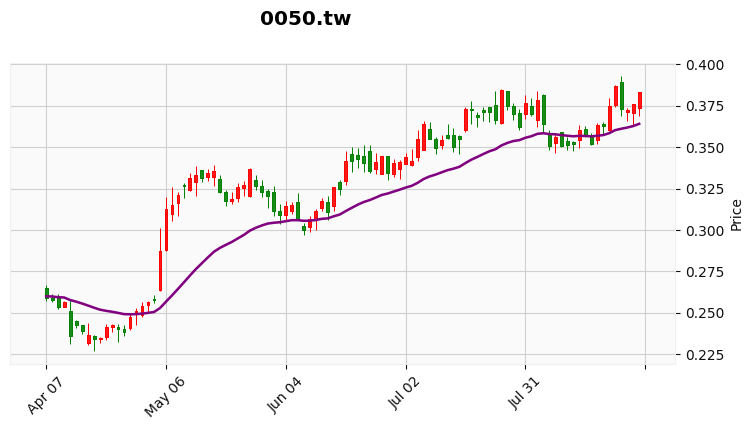

In [17]:
add_plot = [mpf.make_addplot(ema.loc[df.iloc[100:200].index], color='purple', ylabel='EMA', secondary_y=False)]
k_ema_plot = mpf.plot(df.iloc[100:200], style=exterior, type='candle', figratio=(30,14), figscale=0.75, title='0050.tw', addplot=add_plot)

Let's add the moving average of Ta-Lib and try to compare it with the first one we plotted:

In [18]:
sma = talib.SMA(df.iloc[100:200, 3], timeperiod=20)
sma

Date
2003-04-07         NaN
2003-04-08         NaN
2003-04-09         NaN
2003-04-10         NaN
2003-04-11         NaN
                ...   
2003-08-21    0.364911
2003-08-22    0.364321
2003-08-25    0.364205
2003-08-26    0.364500
2003-08-27    0.365571
Length: 100, dtype: float64

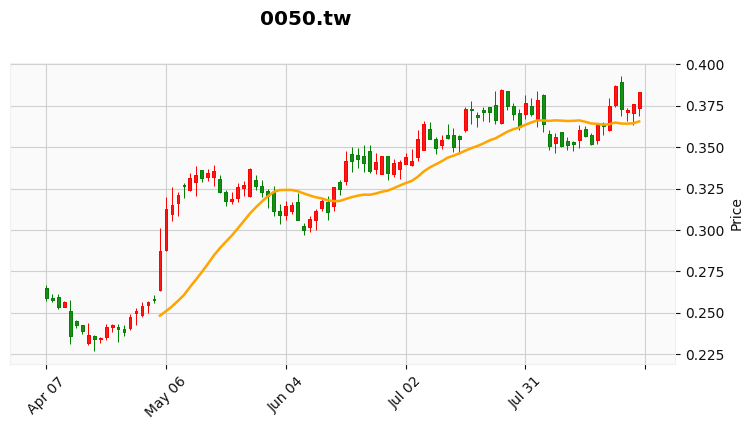

In [21]:
add_plot = [mpf.make_addplot(sma.loc[df.iloc[100:200].index], color='orange', ylabel='SMA', secondary_y=False)]
k_sma_plot = mpf.plot(df.iloc[100:200], style=exterior, type='candle', figratio=(30,14), figscale=0.75, title='0050.tw', addplot=add_plot)

## 4. Data processing

In [22]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-11-11,0.281071,0.283750,0.270000,0.270714,0.230761,152975200
2002-11-12,0.273571,0.286429,0.272857,0.279286,0.238068,223792800
2002-11-13,0.276786,0.286964,0.272857,0.278393,0.237307,231739200
2002-11-14,0.283929,0.293036,0.281786,0.291071,0.248114,141713600
2002-11-15,0.289821,0.290000,0.281429,0.284821,0.242787,160994400


Let's split the df dataset into training and test datasets :

In [23]:
df.drop(['Adj Close', 'Close'], axis = 1, inplace = True)
split_point = int(len(df)*0.8)
train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

In [24]:
# Data normalization
scaler = MinMaxScaler(feature_range=(-1, 1))

#If the data is not one-dimensional, we need to reshape the data and adjust it to (data length,1) 

train_set= train.values
train_sc = scaler.fit_transform(train_set)

test_set= test.values
test_sc = scaler.fit_transform(test_set)

In [25]:
predict_days = 1 
X_train = train_sc[:-predict_days]
y_train = train_sc[predict_days:]
X_test = test_sc[:-predict_days]
y_test = test_sc[predict_days:]

In [26]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4026, 4) (4026, 4) (1006, 4) (1006, 4)


## 5. The first model: Application of the LSTM on a learned representation

### 5.1. The idea : (Original, but not yet well realized)

Tal-Lib provides many tools to process financial data, each tool gives a specific representation of the input data, like for example OHCL quadruplets (Open, High, Close, Low). In a more sophisticated way, a representation can be modeled by a function $\phi$ that maps a qaudruplet, or a tuplet of quadruplets, into a specific space $E$.

Thus, instead of using a pre-existing $\phi$ function to recognize transaction patterns or to make time series predictions, the model will learn it.

The first part of the model is a classical Feed Forward network that takes as input the 4 OHCL variables and represents them in a higher dimensional space (e.g. 10), the second part is an LSTM layer followed by a dropout, and finally a similar inverted Feed Forward network to return to dimension 4.

### 5.2. Building the model

In [27]:
# Build LSTM model
model = Sequential()

# First Part
model.add(Input(shape=(4, 1)))
model.add(Dense(10))

# LSTM layer
model.add(LSTM(units=50, return_sequences=False, input_shape=(10,1)))

# Forgetting layer
model.add(Dropout(0.2))

# Last part & output
model.add(Dense(10))
model.add(Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#Use EarlyStopping to avoid wasting time
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4, 10)             20        
                                                                 
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 12,774
Trainable params: 12,774
Non-trainable params: 0
_________________________________________________________________


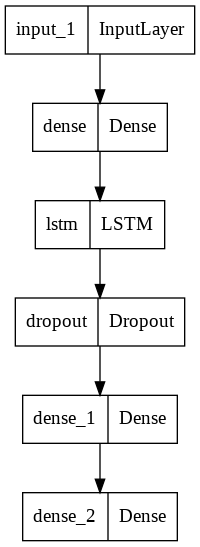

In [29]:
plot_model(model, 'model.png')

In [30]:
history_lstm_model = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2, shuffle=True, callbacks=[early_stop])

Epoch 1/20
4026/4026 - 19s - loss: 0.0151 - accuracy: 0.5857 - 19s/epoch - 5ms/step
Epoch 2/20
4026/4026 - 12s - loss: 0.0079 - accuracy: 0.6493 - 12s/epoch - 3ms/step
Epoch 3/20
4026/4026 - 11s - loss: 0.0073 - accuracy: 0.6570 - 11s/epoch - 3ms/step
Epoch 4/20
4026/4026 - 11s - loss: 0.0072 - accuracy: 0.6657 - 11s/epoch - 3ms/step
Epoch 5/20
4026/4026 - 11s - loss: 0.0070 - accuracy: 0.6781 - 11s/epoch - 3ms/step
Epoch 6/20
4026/4026 - 11s - loss: 0.0068 - accuracy: 0.6818 - 11s/epoch - 3ms/step
Epoch 7/20
4026/4026 - 11s - loss: 0.0069 - accuracy: 0.6788 - 11s/epoch - 3ms/step
Epoch 8/20
4026/4026 - 11s - loss: 0.0068 - accuracy: 0.6893 - 11s/epoch - 3ms/step
Epoch 8: early stopping


Text(0.5, 1.0, 'Accuracy')

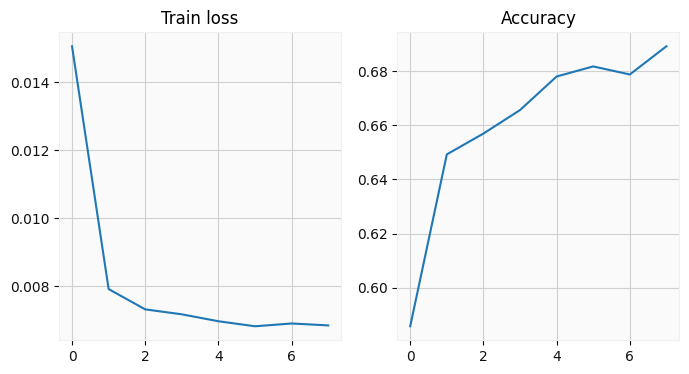

In [31]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(history_lstm_model.history['loss'])
plt.title("Train loss")
ax = plt.subplot(1, 2, 2)
plt.plot(history_lstm_model.history['accuracy'])
plt.title("Accuracy")

### 5.3. Model predictions


32/32 [==============================] - 0s 3ms/step


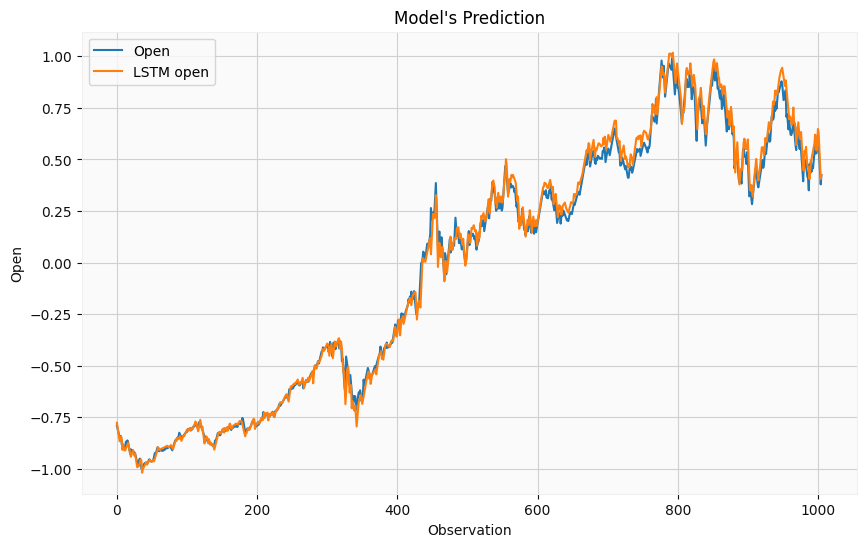

In [32]:
y_pred_test_lstm = model.predict(X_test) #Predict
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Open')
plt.plot(y_pred_test_lstm[:, 0], label='LSTM open')
plt.title("Model's Prediction")
plt.xlabel('Observation')
plt.ylabel('Open')
plt.legend()
plt.show();

### 5.4. Evaluation

In [34]:
#Restore the normalized data
reduction_Lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
reduction_test = df.iloc[split_point:].copy()
reduction_y_test = reduction_test[predict_days:]

In [35]:
#Model Evaluation
print("Mean Absolute Error:", mean_absolute_error(reduction_y_test, reduction_Lstm_pred))
print('Mean Squared Error:', mean_squared_error(reduction_y_test, reduction_Lstm_pred))
print('Root Mean Squared Error:', sqrt(mean_squared_error(reduction_y_test, reduction_Lstm_pred)))
print("Coefficient of Determination:", r2_score(reduction_y_test, reduction_Lstm_pred))

Mean Absolute Error: 7376895.200986264
Mean Squared Error: 449738190419145.56
Root Mean Squared Error: 21207031.626777604
Coefficient of Determination: 0.8475067286882992


## 6. The second model : LSTM on autoencoded representation

Since it seems that the first idea doesn't work well, or it's more the way I implemented it that is bad!

Here, I'm going to try to divide the time series data into 10x4 windows, and try to compress each of these windows by an encoder to get the representation I've talked about so far.

In [36]:
window_length = 10
encoding_dim = 3
epochs = 20

In [37]:
X_train_windows = np.array([X_train[i-window_length:i] for i in tqdm(range(window_length+1,len(X_train)))])
y_train_windows = np.array([y_train[i-window_length:i] for i in tqdm(range(window_length+1,len(y_train)))])
X_test_windows = np.array([X_test[i-window_length:i] for i in tqdm(range(window_length+1,len(X_test)))])
y_test_windows = np.array([y_test[i-window_length:i] for i in tqdm(range(window_length+1,len(y_test)))])

100%|██████████| 995/995 [00:00<00:00, 900395.36it/s]


In [38]:
X_train_windows.shape, y_train_windows.shape, X_test_windows.shape, y_test_windows.shape

((4015, 10, 4), (4015, 10, 4), (995, 10, 4), (995, 10, 4))

In [46]:
inputs = Input(shape=(window_length, 4))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(4, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#Binary cross-entropy is the best

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 3)                 96        
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 3)            0         
 or)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 10, 4)             128       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = sequence_autoencoder.fit(X_train_windows, y_train_windows,
                epochs=epochs,
                batch_size=500,
                shuffle=True,
                validation_data=(y_test_windows, y_test_windows))

Epoch 1/20
9/9 [==============================] - 5s 101ms/step - loss: -6.3077 - val_loss: -2.0248
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: -6.5018 - val_loss: -2.1191
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: -6.6345 - val_loss: -2.2369
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: -6.7475 - val_loss: -2.4153
Epoch 5/20
9/9 [==============================] - 0s 10ms/step - loss: -6.8850 - val_loss: -2.6437
Epoch 6/20
9/9 [==============================] - 0s 10ms/step - loss: -7.0275 - val_loss: -2.9136
Epoch 7/20
9/9 [==============================] - 0s 8ms/step - loss: -7.3092 - val_loss: -3.4612
Epoch 8/20
9/9 [==============================] - 0s 9ms/step - loss: -8.2604 - val_loss: -3.9106
Epoch 9/20
9/9 [==============================] - 0s 8ms/step - loss: -8.6517 - val_loss: -3.9918
Epoch 10/20
9/9 [==============================] - 0s 8ms/step - loss: -8.7551 - val_loss: -4.0093
Epoch 11/20
9

Text(0.5, 1.0, 'Test loss')

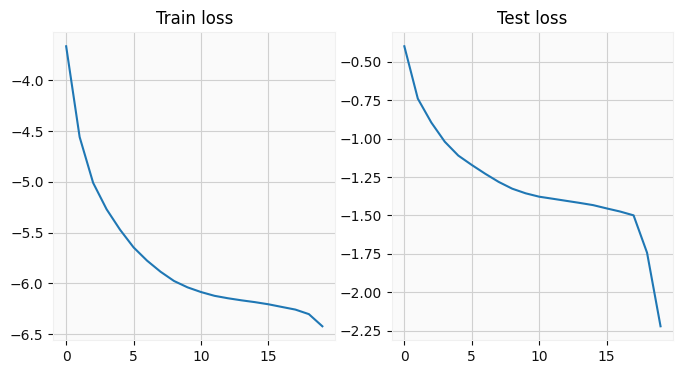

In [41]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.title("Train loss")
ax = plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"])
plt.title("Test loss")

In [42]:
decoded_stocks = sequence_autoencoder.predict(X_test_windows)

32/32 [==============================] - 1s 4ms/step


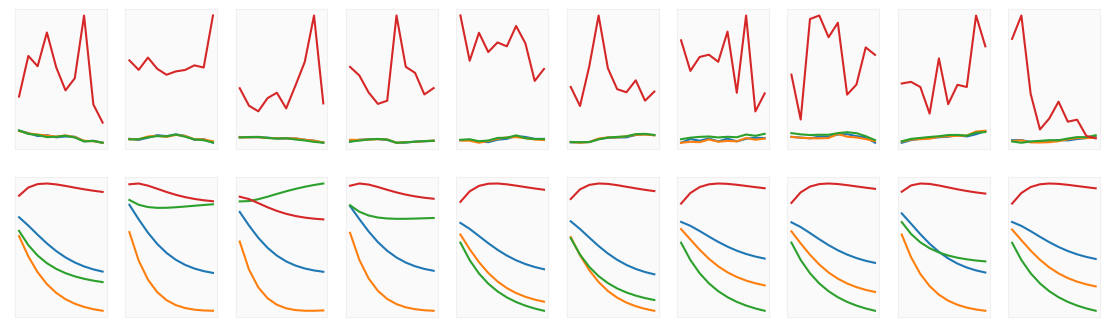

In [45]:
plt.figure(figsize=(14, 4))

for i in range(10):
  # display original
  ax = plt.subplot(2, 10, i + 1)
  ax.get_yaxis().set_visible(False)
  plt.plot(X_test_windows[i*10])
  ax.get_xaxis().set_visible(False)
        
  # display reconstruction
  ax = plt.subplot(2, 10, i + 11)
  ax.get_yaxis().set_visible(False)
  plt.plot(decoded_stocks[i*10])
  ax.get_xaxis().set_visible(False)